# Install Libraries

In [1]:
import sys
! {sys.executable} -m pip install pandas
! {sys.executable} -m pip install Pillow
! {sys.executable} -m pip install matplotlib
! {sys.executable} -m pip install wordcloud
! {sys.executable} -m pip install seaborn

# Load Data

In [ ]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

import string
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
my_spark = SparkSession .\
    builder .\
    appName("myApp") .\
    config("spark.mongodb.input.uri", "mongodb://13.76.131.54:27017/cord19dataset.metadata") .\
    config("spark.mongodb.output.uri", "mongodb://13.76.131.54:27017/cord19dataset.metadata") .\
    config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.0").\
    getOrCreate()

In [ ]:
metadata = my_spark.read.format("mongo").load()

# Compute Statistics

In [ ]:
metadata.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- arxiv_id: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- cord_uid: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- license: string (nullable = true)
 |-- mag_id: string (nullable = true)
 |-- pdf_json_files: string (nullable = true)
 |-- pmc_json_files: string (nullable = true)
 |-- pmcid: string (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- pubmed_id: string (nullable = true)
 |-- s2_id: string (nullable = true)
 |-- sha: string (nullable = true)
 |-- source_x: string (nullable = true)
 |-- title: string (nullable = true)
 |-- url: string (nullable = true)
 |-- who_covidence_id: string (nullable = true)



In [ ]:
metadata.show(1)

+--------------------+--------------------+--------+--------------------+--------+--------------------+--------------+-------+------+--------------------+--------------------+--------+------------+---------+-----+--------------------+--------+--------------------+--------------------+----------------+
|                 _id|            abstract|arxiv_id|             authors|cord_uid|                 doi|       journal|license|mag_id|      pdf_json_files|      pmc_json_files|   pmcid|publish_time|pubmed_id|s2_id|                 sha|source_x|               title|                 url|who_covidence_id|
+--------------------+--------------------+--------+--------------------+--------+--------------------+--------------+-------+------+--------------------+--------------------+--------+------------+---------+-----+--------------------+--------+--------------------+--------------------+----------------+
|[5fa63686ba5766d2...|OBJECTIVE: This r...|        |Madani, Tariq A; ...|ug7v899j|10.1186/1

In [ ]:
today_titles = metadata.select("title").filter("publish_time='2020-10-25'").toPandas()

In [ ]:
today_titles.head()

,title
0,Diagnostic Testing of COVID-19 in Solid Organ ...
1,"E-cigarette, or vaping, product use-associated..."
2,Response to “Comment on Mastellos and colleagu...
3,The Silent Epidemic
4,"COVID-19, steroids and other immunomodulators:..."


In [ ]:
title_text = ''

for title in today_titles['title']:
    words = title.translate(str.maketrans('', '', string.punctuation)).lower().split(' ')
    title_text += ' '.join(words) + ' '

In [ ]:
authors = metadata.select("authors").toPandas()

In [ ]:
authors.head()

,authors
0,"Madani, Tariq A; Al-Ghamdi, Aisha A"
1,"Vliet, Albert van der; Eiserich, Jason P; Cros..."
2,"Crouch, Erika C"
3,"Domachowske, Joseph B; Bonville, Cynthia A; Ro..."
4,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M"


In [ ]:
authors_count = {}

for aus in authors['authors']:
    au_list = aus.split('; ')
    for au in au_list:
        if au in authors_count:
            authors_count[au] += 1
        else:
            authors_count[au] = 1

In [ ]:
sorted_authors_count = {k: v for k, v in sorted(authors_count.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
sorted_authors_count

{'': 10265,
 'O039,': 832,
 'Anonymous,': 811,
 'D039,': 611,
 'Wang, Wei': 353,
 'Yuen, Kwok-Yung': 330,
 'Wiwanitkit, Viroj': 329,
 'Li, Yan': 292,
 'Zhang, Wei': 291,
 'Mahase, Elisabeth': 291,
 'Drosten, Christian': 263,
 'Jiang, Shibo': 242,
 'Liu, Wei': 233,
 'Li, Wei': 231,
 'Iacobucci, Gareth': 231,
 'Wang, Jing': 214,
 'Lippi, Giuseppe': 213,
 'Perlman, Stanley': 212,
 'Liu, Yang': 207,
 'Rimmer, Abi': 198,
 'Zhang, Lei': 197,
 'Zhang, Yi': 192,
 'Wang, Ying': 191,
 'Li, Li': 188,
 'Liu, Jun': 184,
 'Siddiqui, Adnan H': 183,
 'Chen, Wei': 181,
 'Zhang, Li': 179,
 'Wang, Jian': 178,
 'Zumla, Alimuddin': 178,
 'Yang, Yang': 177,
 'Li, Jing': 172,
 'Zhang, Yan': 171,
 'Wang, Yan': 171,
 'Wang, Tao': 170,
 'Chen, Yu': 168,
 'Zhang, Jing': 167,
 'Liu, Lei': 166,
 'Wang, Li': 165,
 'Levy, Elad I': 163,
 'Wang, Jun': 159,
 'Chan, Kwok-Hung': 158,
 'Wang, Lin-Fa': 158,
 'Li, Hui': 157,
 'Raoult, Didier': 151,
 'Wang, Hui': 150,
 'Baric, Ralph S.': 147,
 'Liu, Jing': 144,
 'Enjuanes, L

In [ ]:
journals = metadata.select("journal").toPandas()

In [ ]:
journals.head()

,journal
0,BMC Infect Dis
1,Respir Res
2,Respir Res
3,Respir Res
4,Respir Res


In [ ]:
journals_count = dict(journals.groupby('journal')['journal'].count())

In [ ]:
sorted_journals_count = {k: v for k, v in sorted(journals_count.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
sorted_journals_count

{'': 20264,
 'bioRxiv': 3104,
 'BMJ': 3089,
 'PLoS One': 2648,
 'Journal of virology': 1893,
 'Lancet': 1508,
 'Nature': 1450,
 'Sci Rep': 1129,
 'JAMA': 1075,
 'Emerg Infect Dis': 1060,
 'J Med Virol': 1048,
 'Science': 994,
 'Virology': 978,
 'Viruses': 969,
 'Surgical endoscopy': 942,
 'Chest': 878,
 'Crit Care': 864,
 'Cureus': 859,
 'Clin Infect Dis': 855,
 'Int J Infect Dis': 853,
 'J. med. virol': 774,
 'Arch Virol': 721,
 'Vaccine': 716,
 'Int J Environ Res Public Health': 696,
 'Lancet Infect Dis': 681,
 'Sci Total Environ': 666,
 'Dermatol Ther': 648,
 'J Infect': 644,
 'Med Hypotheses': 623,
 'Front Immunol': 619,
 'The Journal of general virology': 608,
 'Intensive Care Med': 576,
 'J Infect Dis': 569,
 'BMC Infect Dis': 567,
 'J Clin Virol': 558,
 'Nat Commun': 545,
 'Proceedings of the National Academy of Sciences of the United States of America': 533,
 'J Med Internet Res': 529,
 'N Engl J Med': 506,
 'Journal of neurointerventional surgery': 495,
 'AJNR. American journa

In [ ]:
licenses = metadata.select("license").toPandas()

In [ ]:
licenses.head()

,license
0,no-cc
1,no-cc
2,no-cc
3,no-cc
4,no-cc


In [ ]:
licenses_count = dict(licenses.groupby('license')['license'].count())

In [ ]:
sorted_licenses_count = {k: v for k, v in sorted(licenses_count.items(), key=lambda item: item[1], reverse=True)}

In [ ]:
sorted_licenses_count

{'unk': 170752,
 'no-cc': 66404,
 'cc-by': 32516,
 'els-covid': 21244,
 'medrxiv': 7024,
 'cc-by-nc': 6499,
 'cc-by-nc-nd': 5484,
 'arxiv': 3994,
 'biorxiv': 2495,
 'cc-by-nc-sa': 1735,
 'green-oa': 848,
 'bronze-oa': 654,
 'cc0': 364,
 'cc-by-nd': 221,
 'hybrid-oa': 131,
 'pd': 71,
 'gold-oa': 56,
 'cc-by-sa': 26}

In [ ]:
dates = metadata.select("publish_time").toPandas()

In [ ]:
dates.head()

,publish_time
0,2001-07-04
1,2000-08-15
2,2000-08-25
3,2001-05-11
4,2001-02-22


In [ ]:
dates_count = dict(dates.groupby('publish_time')['publish_time'].count())

In [ ]:
cleaned_dates = {key:val for key, val in dates_count.items() if len(key) == 10}

In [ ]:
sorted_dates_count = {k: v for k, v in sorted(cleaned_dates.items(), key=lambda item: item[0])}

In [ ]:
sorted_dates_count

{'1955-10-31': 1,
 '1957-08-01': 1,
 '1957-10-01': 1,
 '1961-09-28': 1,
 '1962-09-01': 1,
 '1963-05-01': 1,
 '1964-01-01': 1,
 '1964-02-01': 1,
 '1965-01-01': 1,
 '1967-03-31': 1,
 '1968-07-01': 1,
 '1969-03-28': 1,
 '1969-11-08': 1,
 '1969-11-28': 1,
 '1970-01-01': 1,
 '1970-03-07': 1,
 '1970-03-31': 2,
 '1970-04-30': 1,
 '1970-05-28': 1,
 '1970-06-28': 1,
 '1970-10-17': 1,
 '1970-10-28': 1,
 '1971-01-01': 1,
 '1971-05-01': 1,
 '1971-06-28': 1,
 '1971-07-28': 1,
 '1971-07-31': 2,
 '1971-11-30': 1,
 '1972-02-28': 1,
 '1972-03-31': 1,
 '1972-05-31': 1,
 '1972-06-01': 1,
 '1972-07-28': 2,
 '1972-08-28': 4,
 '1972-10-01': 1,
 '1972-12-31': 2,
 '1973-01-31': 1,
 '1973-04-30': 2,
 '1973-07-31': 1,
 '1973-08-04': 1,
 '1973-08-28': 1,
 '1973-08-31': 1,
 '1973-09-01': 1,
 '1973-10-01': 1,
 '1973-11-28': 1,
 '1973-11-30': 1,
 '1974-02-28': 1,
 '1974-03-01': 1,
 '1974-03-28': 1,
 '1974-04-01': 1,
 '1974-04-08': 1,
 '1974-09-28': 1,
 '1974-10-15': 1,
 '1974-10-28': 1,
 '1974-11-01': 1,
 '1974-11-

# Plot Data

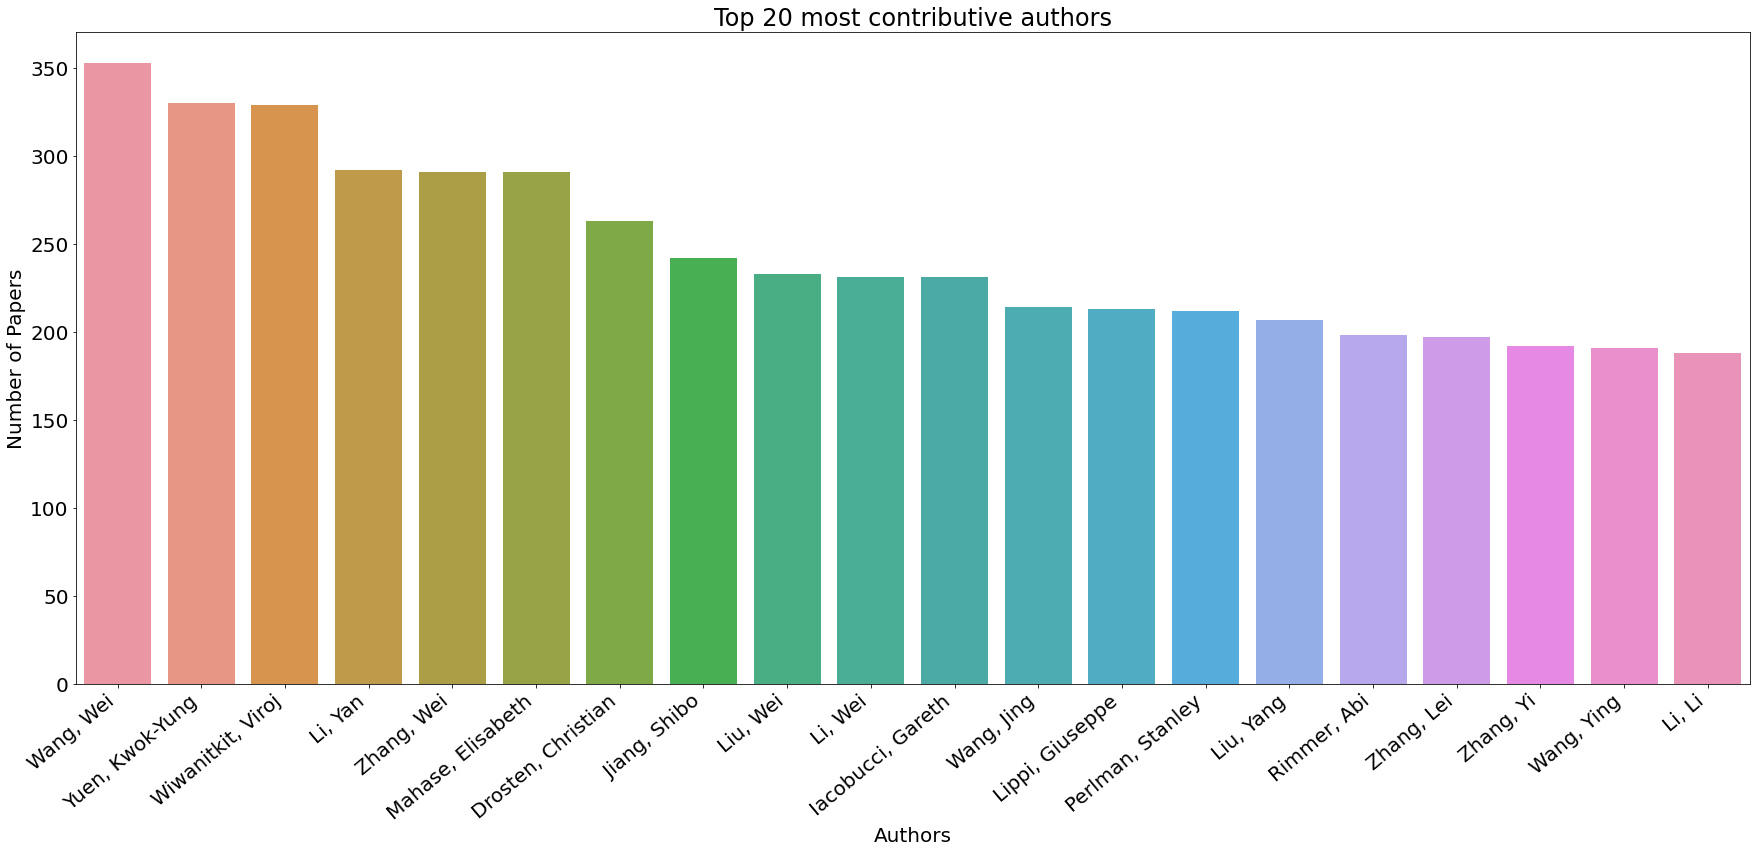

In [ ]:
x = list(sorted_authors_count.keys())[4:24]
y = list(sorted_authors_count.values())[4:24]

font = {'size':20}
plt.rc('font', **font)
plt.figure(figsize=(30,12))
plt.xlabel("Authors")
plt.ylabel("Number of Papers")
plt.title("Top 20 most contributive authors")
bar = sns.barplot(x=x,y=y)
bar.set_xticklabels(bar.get_xticklabels(), rotation=40, ha="right")
plt.savefig('top20authors')
plt.show()

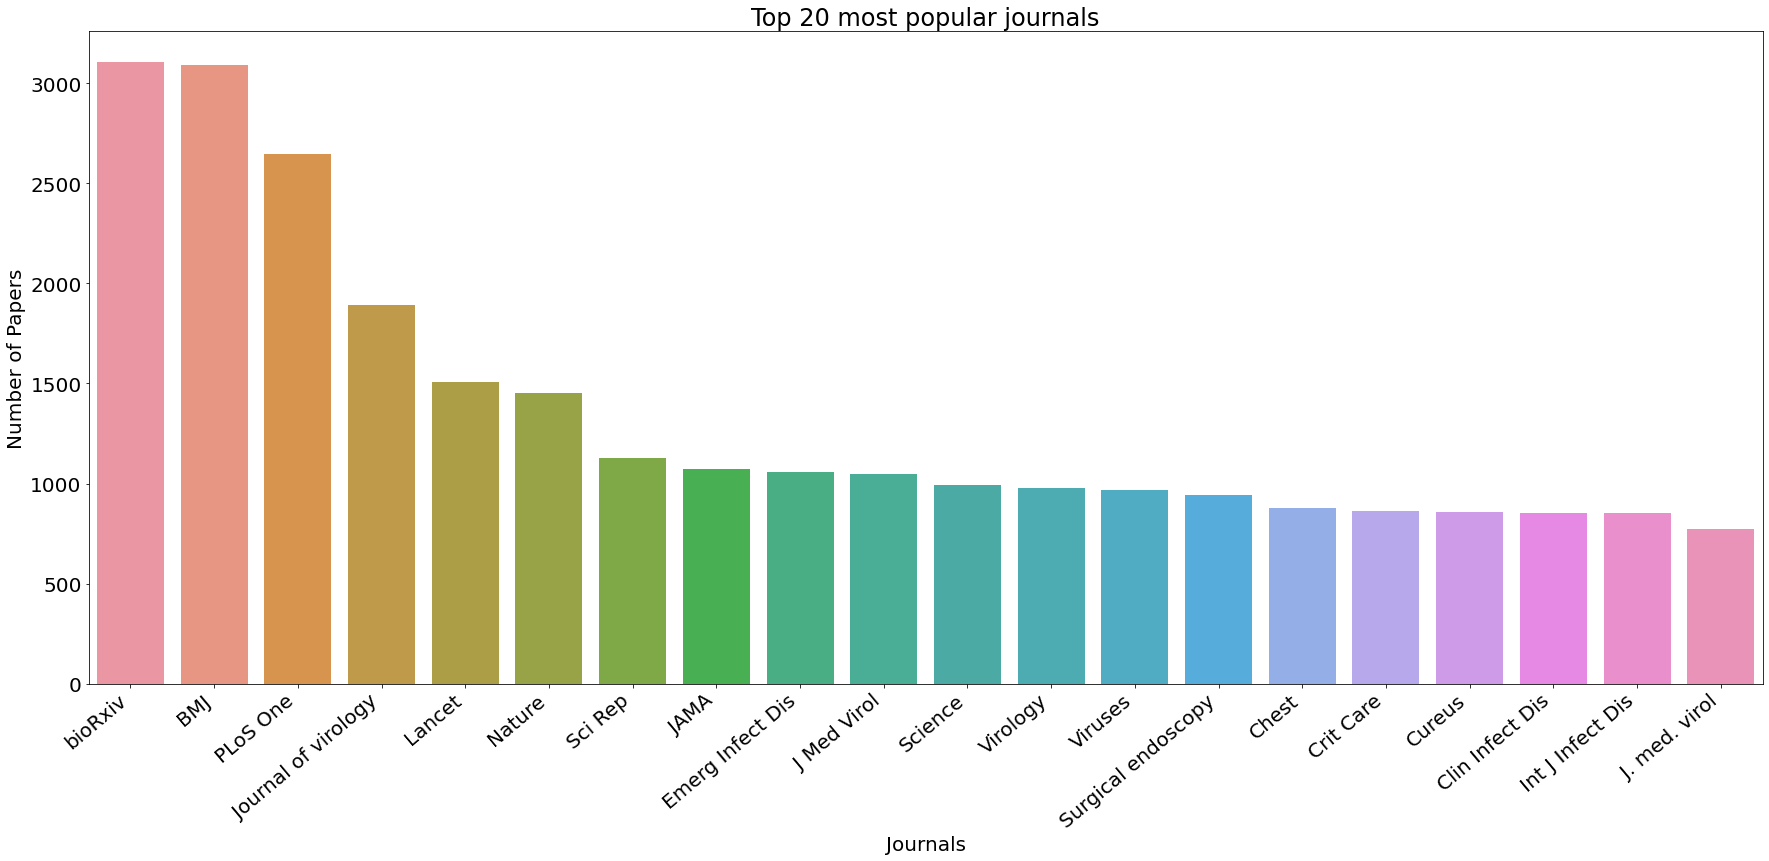

In [ ]:
x = list(sorted_journals_count.keys())[1:21]
y = list(sorted_journals_count.values())[1:21]

plt.figure(figsize=(30,12))
plt.xlabel("Journals")
plt.ylabel("Number of Papers")
plt.title("Top 20 most popular journals")
bar = sns.barplot(x=x,y=y)
bar.set_xticklabels(bar.get_xticklabels(), rotation=40, ha="right")
plt.savefig('top20journals')
plt.show()

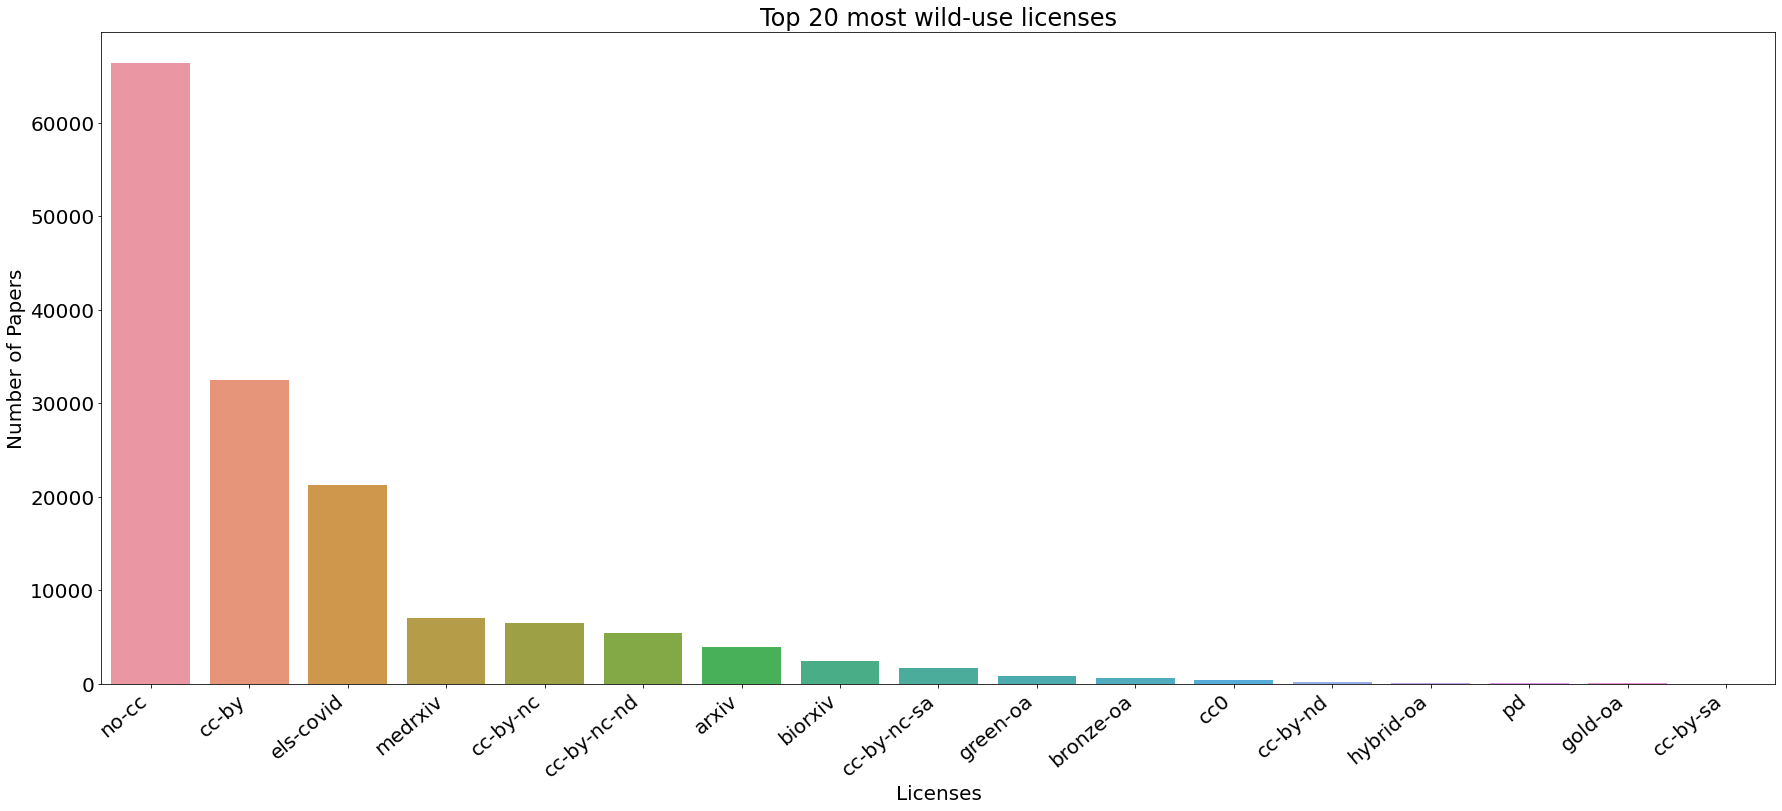

In [ ]:
x = list(sorted_licenses_count.keys())[1:21]
y = list(sorted_licenses_count.values())[1:21]

plt.figure(figsize=(30,12))
plt.xlabel("Licenses")
plt.ylabel("Number of Papers")
plt.title("Top 20 most wild-use licenses")
bar = sns.barplot(x=x,y=y)
bar.set_xticklabels(bar.get_xticklabels(), rotation=40, ha="right")
plt.savefig('top20licenses')
plt.show()

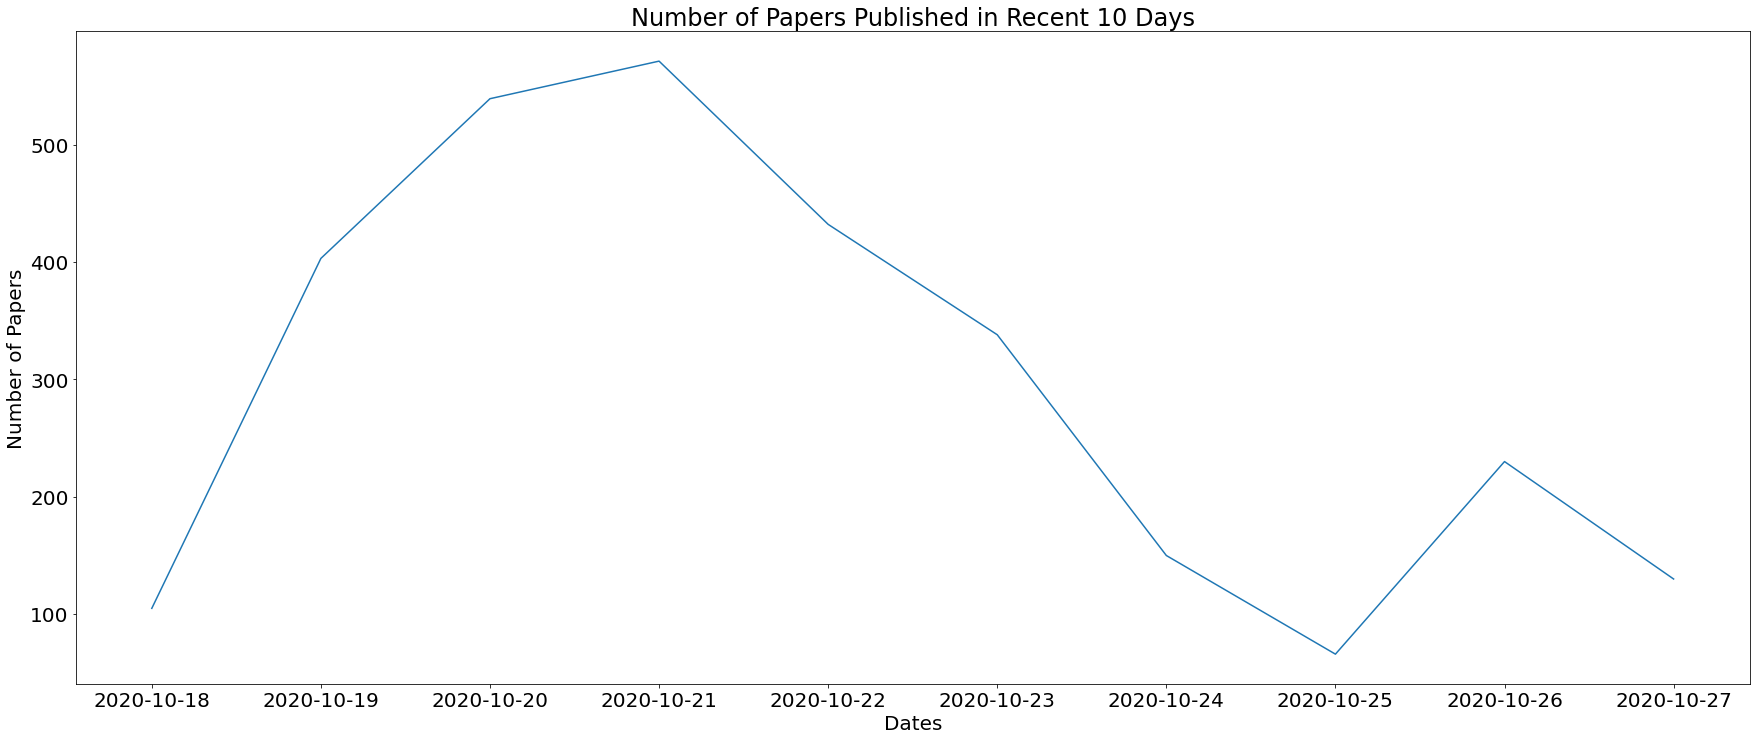

In [ ]:
x = list(sorted_dates_count.keys())[-45:-35]
y = list(sorted_dates_count.values())[-45:-35]

plt.figure(figsize=(30,12))
plt.xlabel("Dates")
plt.ylabel("Number of Papers")
plt.title("Number of Papers Published in Recent 10 Days")
line = sns.lineplot(x=x,y=y)
# line.set_xticklabels(line.get_xticklabels(), rotation=40)
plt.savefig('papers10days')
plt.show()

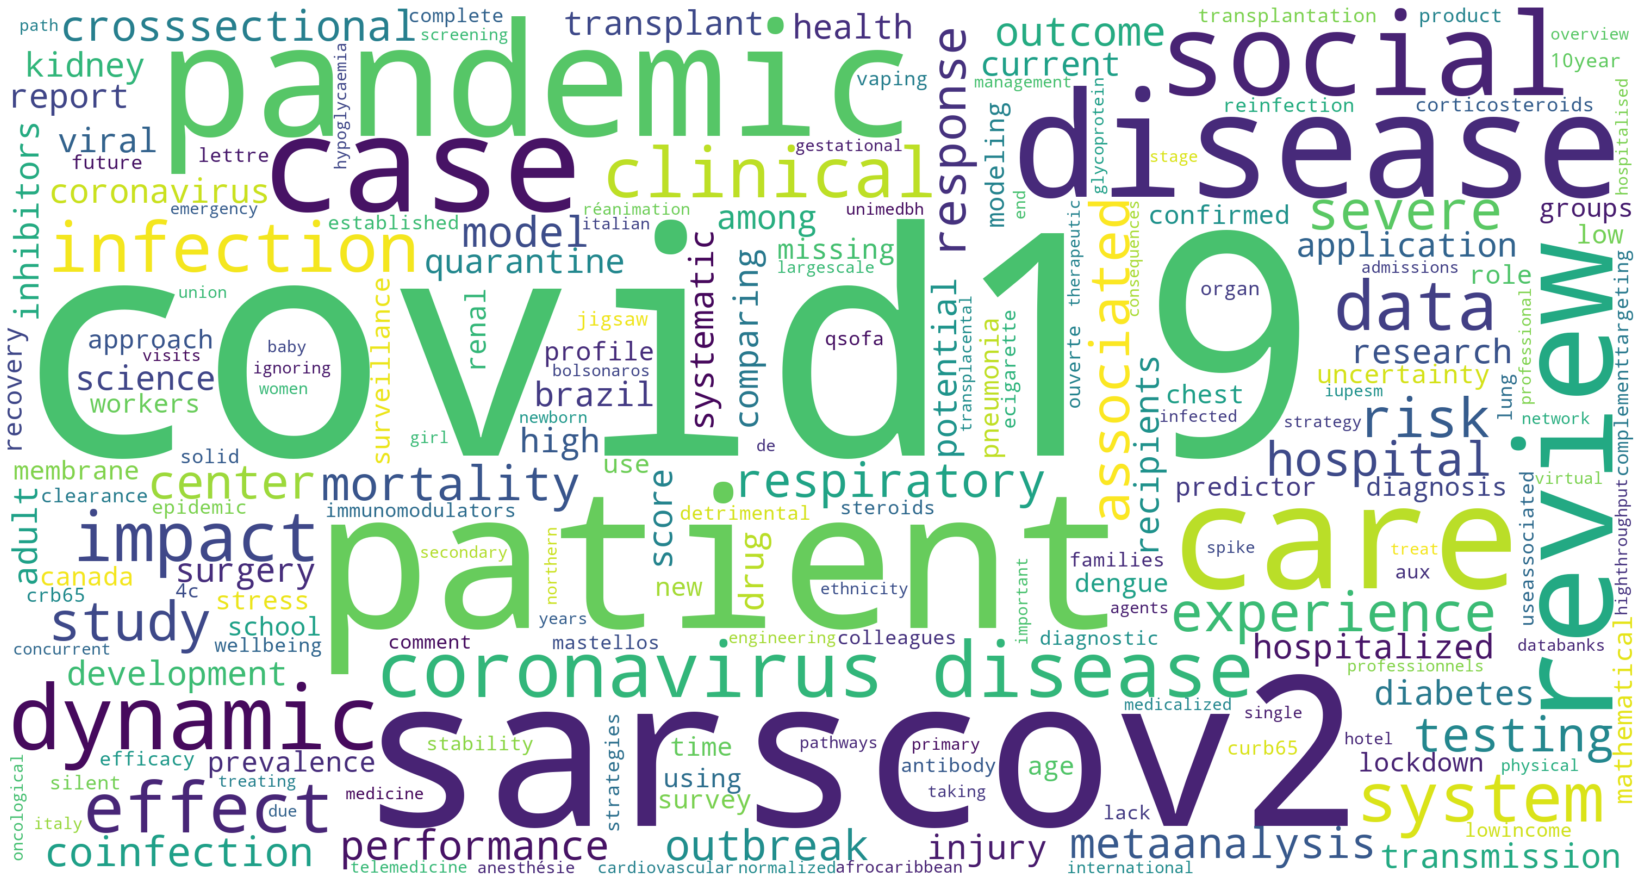

In [ ]:
# Create and generate a word cloud image:
wordcloud = WordCloud(width = 3000, height = 1600, background_color="white").generate(title_text)

# Display the generated image:
plt.figure(figsize=(30,16))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud', dpi='figure')
plt.show()